In [3]:
datasetName = 'brain_rett_William2018'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_rett_William2018")

In [5]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    # data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
    data.matrix <- read.table(file = paste0(datasetName,"_expression.tsv"), h = T, sep = "\t", row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}


In [15]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation.v2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation.v2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [16]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AN15579_170616_1.1_bcEKHK,AN15579_170616_1.1_bcGHSG,AN15579_170616_1.1_bcFNCN,AN15579_170616_1.1_bcCNQB,AN15579_170616_1.1_bcERDV
,<int>,<int>,<int>,<int>,<int>
A1BG,0,1,0,0,0
A1BG-AS1,1,0,0,0,0
A1CF,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AN15579_170616_1.1_bcEKHK,brain,viusal cortex,occipital,rett,AN15579_170616_1,female,8 years
AN15579_170616_1.1_bcGHSG,brain,viusal cortex,occipital,rett,AN15579_170616_1,female,8 years
AN15579_170616_1.1_bcFNCN,brain,viusal cortex,occipital,rett,AN15579_170616_1,female,8 years
AN15579_170616_1.1_bcCNQB,brain,viusal cortex,occipital,rett,AN15579_170616_1,female,8 years
AN15579_170616_1.1_bcERDV,brain,viusal cortex,occipital,rett,AN15579_170616_1,female,8 years


[1] NA NA NA NA NA

In [17]:
dim(data.matrix)

[1] 25463 30293

In [18]:
# Pre-processing
min.cells = 3
min.features = 500
nFeature_RNA_range = c(min.features, 15000)
# percent.mt.thre = 15
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation.v2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2]) # & percent.mt < percent.mt.thre)
dataobj@assays

Warning message in CreateSeuratObject(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


$RNA
Assay data with 21639 features for 30291 cells
First 10 features:
 A1BG, A1BG-AS1, A1CF, A2M, A2M-AS1, A2ML1, A4GALT, A4GNT, AA06, AAAS 


In [19]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, mean.cutoff = c(0.0125, 3), dispersion.cutoff = c(3, Inf)) # default feature number, nfeatures = 2000
length(VariableFeatures(dataobj))
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

[1] 2000

Centering and scaling data matrix



PC_ 1 
Positive:  GLUL, ATP1B2, SLC1A3, AGT, ATP1A2, SLC1A2, AQP4, CST3, GJA1, APOE 
	   SDC4, ZBTB20, PLPP3, SOX2, GPRC5B, HTRA1, NDRG2, SLC6A1, PTGDS, GPR37L1 
	   FGFR3, SOX9, F3, METTL7A, PTN, QKI, BAG3, TIMP3, KCNJ10, MLC1 
Negative:  ENC1, NRGN, CHN1, YWHAH, PRKCB, RTN1, OLFM1, CREG2, VSNL1, SV2B 
	   CAMK2A, LMO4, UCHL1, RGS4, RTN4, MAP1B, NECAB1, TUBA1B, PTK2B, GAP43 
	   PSD3, THY1, MKL2, NUAK1, MEF2C, SNCA, PAK1, ARHGAP32, ARPP19, NELL2 
PC_ 2 
Positive:  GPM6B, SERPINE2, ATP1A2, SLC1A2, SLC1A3, AQP4, AGT, NRGN, ENC1, SOX9 
	   SDC4, GJA1, CST3, APOE, MT2A, PLPP3, NCAN, CLU, ARPP19, CHN1 
	   MT3, SV2B, CAMK2A, HSPB1, GPR37L1, PSD3, FGFR3, TTYH1, F3, JUN 
Negative:  GAD1, GAD2, DLX6-AS1, ZNF385D, MAFB, ARL4C, ERBB4, SLC6A1, SYNPR, SLC32A1 
	   DNER, NRIP3, ARX, ADARB2, MAF, NR2F2, CXCL14, PROX1, PCP4L1, KIT 
	   DLX1, BCL11B, PVALB, TAC1, SST, CALB2, NXPH1, LHX6, KCNAB1, IGF1 
PC_ 3 
Positive:  GAD1, GAD2, IFITM1, RGS5, IFITM3, ZNF385D, ARL4C, SLC6A1, RAB3C, SRGN 
	   HSPA8, 

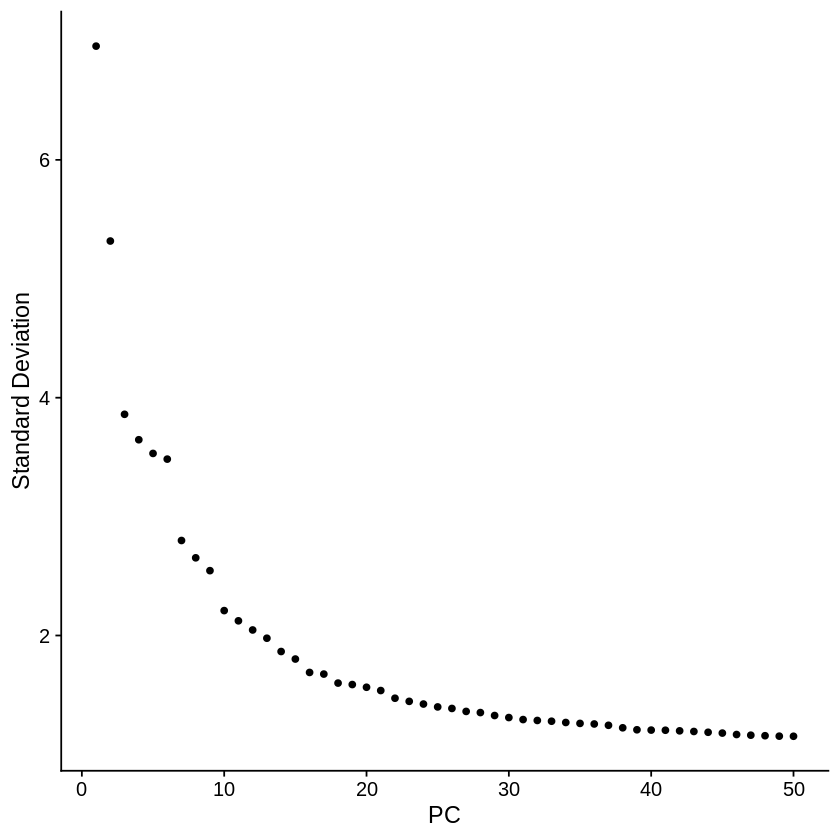

In [20]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
ElbowPlot(dataobj, ndims = 50) 

In [21]:
dev.off()
pcDim = 30 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
08:35:11 UMAP embedding parameters a = 0.9922 b = 1.112

08:35:11 Read 30291 rows and found 30 numeric columns

08:35:11 Using Annoy for neighbor search, n_neighbors = 30

08:35:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

08:35:20 Writing NN index file to temp file /tmp/RtmpSDApSU/file2d7543afc73f

08:35:20 Searching Annoy index using 1 thread, search_k = 3000

08:35:35 Annoy recall = 100%

08:35:36 Commencing smooth kNN distance calibration using 1 thread

08:35:38 Initializing f

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30291
Number of edges: 1148543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8942
Number of communities: 28
Elapsed time: 9 seconds


08:38:18 UMAP embedding parameters a = 0.9922 b = 1.112

08:38:18 Read 30291 rows and found 30 numeric columns

08:38:18 Using Annoy for neighbor search, n_neighbors = 30

08:38:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

08:38:26 Writing NN index file to temp file /tmp/RtmpSDApSU/file2d756ff2a49f

08:38:27 Searching Annoy index using 1 thread, search_k = 3000

08:38:42 Annoy recall = 100%

08:38:43 Commencing smooth kNN distance calibration using 1 thread

08:38:45 Initializing from normalized Laplacian + noise

08:38:48 Commencing optimization for 200 epochs, with 1365206 positive edges

08:39:37 Optimization finished



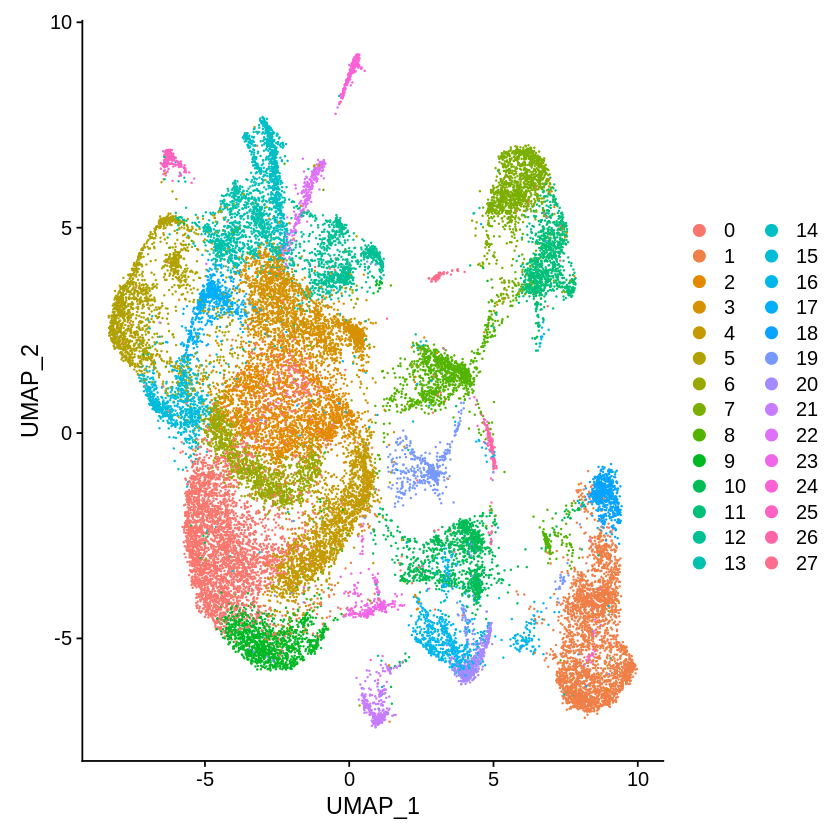

In [22]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim)
dataobj <- FindClusters(dataobj)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap")

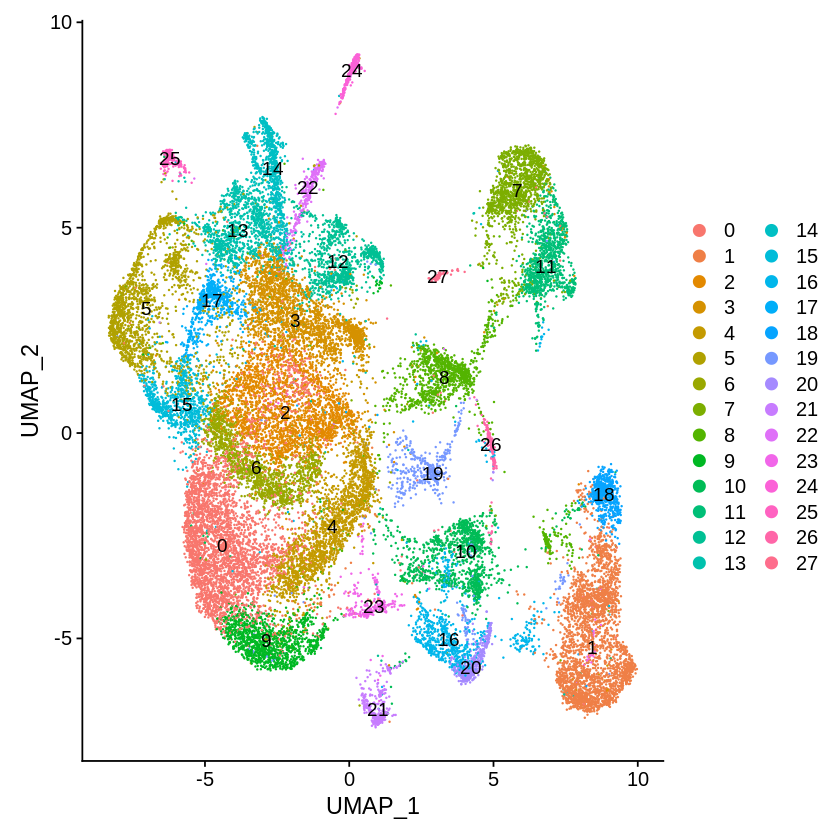

In [24]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [31]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

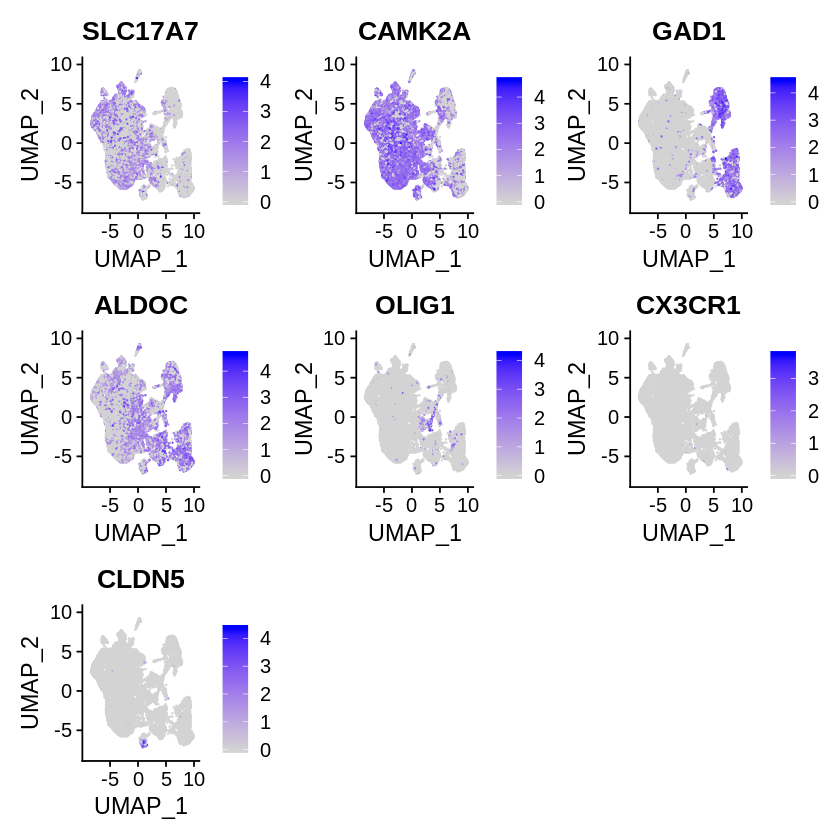

In [12]:
# Excitatory neurons were marked by the expression of (SLC17A7) and (CAMK2A). 
# Interneurons were marked by (GAD1), and were further separated into three major subtypes by the expression of (PVALB), (VIP), or (SST). 
# Astrocytes were marked by the expression of (ALDOC)
# oligodendrocytes by the expression of OLIG1
# microglia by the expression of CX3CR1
# endothelial cells by the expression of CLDN5.
p <- FeaturePlot(dataobj, features = c("SLC17A7", "CAMK2A", "GAD1", "ALDOC", "OLIG1", "CX3CR1", "CLDN5"))
p

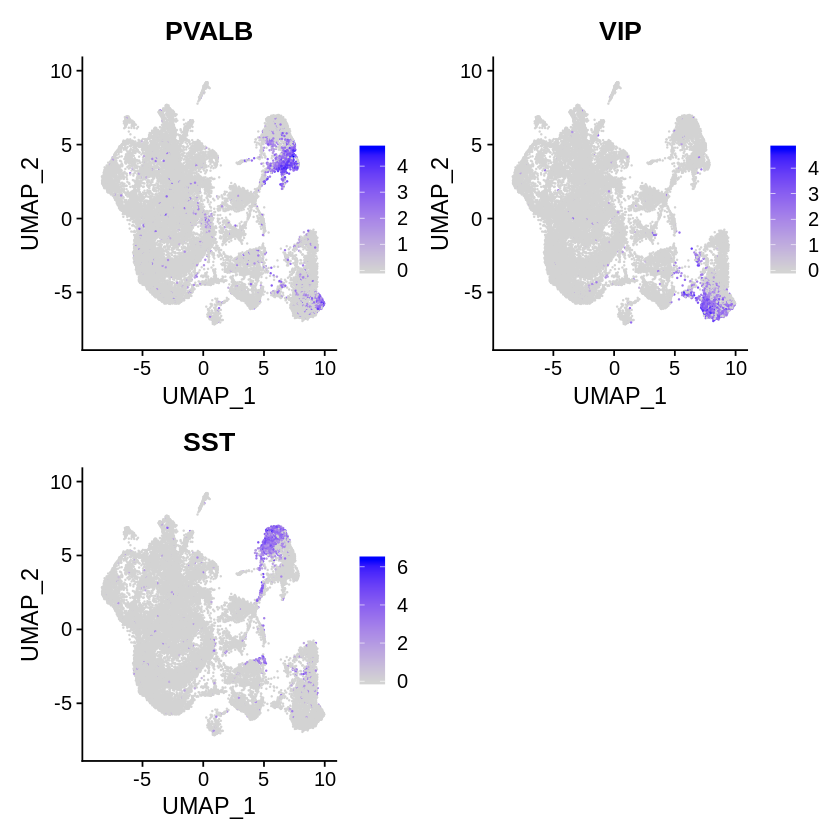

In [13]:
psub <- FeaturePlot(dataobj, features = c("PVALB", "VIP", "SST"))
psub

In [15]:
ggsave(paste0(datasetName,".featuremap2.tiff"), plot = psub, width = 10, height = 10)

In [45]:
library(SingleR)
hpca.se <- HumanPrimaryCellAtlasData()
hpca.se

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

snapshotDate(): 2019-10-22

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

loading from cache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

loading from cache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache

Using temporary cache /tmp/Rtmp60p1Ag/BiocFileCache



class: SummarizedExperiment 
dim: 19363 713 
metadata(0):
assays(1): logcounts
rownames(19363): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(713): GSM112490 GSM112491 ... GSM92233 GSM92234
colData names(2): label.main label.fine

ERROR: Error in .identify_genes(ref, labels, genes = genes, sd.thresh = sd.thresh, : number of labels must be equal to number of cells


In [54]:
pred.hesc <- SingleR(test = as.matrix(GetAssayData(object = dataobj, slot = "data")), ref = hpca.se, labels = hpca.se$label.main,
                    fine.tune = TRUE)
pred.hesc

DataFrame with 30291 rows and 5 columns
                                                                                scores
                                                                              <matrix>
AN15579_170616_1.1_bcEKHK   0.0646271600944874:0.148023083988511:0.102582519003417:...
AN15579_170616_1.1_bcGHSG   0.0791936130657563:0.145117878080732:0.108054187239142:...
AN15579_170616_1.1_bcFNCN  0.0513955450938017:0.119473743791625:0.0725692523111635:...
AN15579_170616_1.1_bcCNQB 0.0422150928920924:0.0926155390493824:0.0589631115248033:...
AN15579_170616_1.1_bcERDV   0.0747914201741461:0.11166897565417:0.0797868627686339:...
...                                                                                ...
AN08016_170616_3.3_bcCVXW 0.0170683674541008:0.0437080026192019:0.0362080075581234:...
AN08016_170616_3.3_bcHGHK 0.0273437340811815:0.0730498033963093:0.0430547050560018:...
AN08016_170616_3.3_bcAHOC 0.0251548539082302:0.0690769068527192:0.0600607374503304:...
AN0

In [55]:
table(pred.hesc$labels)


           Astrocyte         Chondrocytes                   DC 
               26186                    4                    4 
   Endothelial_cells          Fibroblasts          Gametocytes 
                  67                    2                    2 
          Macrophage             Monocyte Neuroepithelial_cell 
                   5                    3                 1305 
             Neurons              NK_cell          Osteoblasts 
                2690                    1                    1 
           Platelets  Smooth_muscle_cells    Tissue_stem_cells 
                   1                   11                    9 

In [61]:
write.table(pred.hesc, file = paste0(datasetName,".singleR.tsv"), quote = FALSE, sep = "\t",
            eol = "\n", na = "NA", dec = ".", row.names = TRUE, col.names = TRUE)

In [25]:
# 'Excitatory neurons', 'Interneurons', 'Oligodendrocytes', 'Microglia', 'Astrocytes', 'Vascular cells'
new.cluster.ids <- c('Brain-Nerve tissue-Excitatory neurons-CAMK2A','Brain-Nerve tissue-Interneurons-VIP','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                     'Brain-Nerve tissue-Excitatory neurons-CAMK2A','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                  'Brain-Nerve tissue-Excitatory neurons-CAMK2A','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                     'Brain-Nerve tissue-Astrocytes-ALDOC','Brain-Nerve tissue-Microglia-CX3CR1','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                  'Brain-Nerve tissue-Astrocytes-ALDOC','Brain-Nerve tissue-Interneurons-PVALB','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                     'Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                     'Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                  'Brain-Nerve tissue-Excitatory neurons-CAMK2A','Brain-Nerve tissue-Astrocytes-ALDOC',
                     'Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                     'Brain-Nerve tissue-Interneurons-GAD1','Brain-Nerve tissue-Oligodendrocytes-OLIG1',
                  'Brain-Nerve tissue-Astrocytes-ALDOC','Brain-Epithelial tissue-Vascular cells-CLDN5','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                     'Brain-Nerve tissue-Excitatory neurons-CAMK2A','Brain-Nerve tissue-Excitatory neurons-CAMK2A',
                  'Brain-Nerve tissue-Excitatory neurons-CAMK2A','Brain-Nerve tissue-Astrocytes-ALDOC','Brain-Nerve tissue-Interneurons-GAD1')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

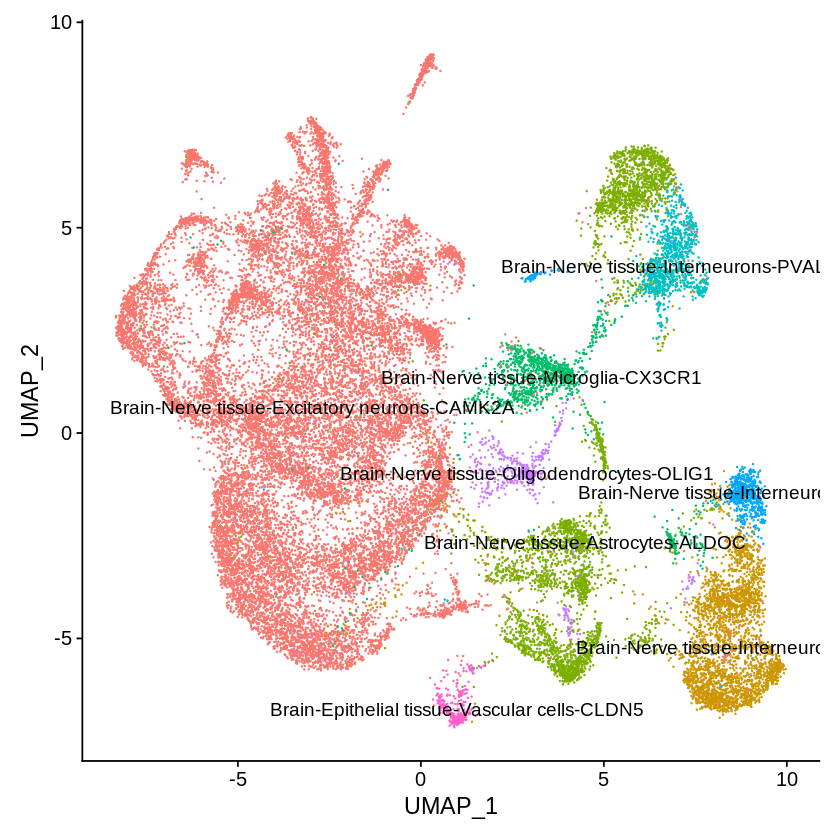

In [27]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+NoLegend()
p_umap2

In [28]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [14]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27



In [20]:
cluster8 <- FindMarkers(dataobj, only.pos = FALSE, min.pct = 0.25, logfc.threshold = 0.25, ident.1=8)

In [25]:
cluster8 <- cluster8[order(-abs(cluster8$avg_logFC)), ]
cluster8
write.table(cluster8, file = paste0(datasetName,".seurat.markers.cluster8.txt"), sep = "\t", quote = F, row.names = T, col.names = T)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PLP1,0.000000e+00,3.159061,0.942,0.059,0.000000e+00
TF,0.000000e+00,2.309109,0.632,0.029,0.000000e+00
CNP,0.000000e+00,2.099787,0.777,0.172,0.000000e+00
MAG,0.000000e+00,2.079401,0.543,0.015,0.000000e+00
CLDN11,0.000000e+00,2.070637,0.569,0.024,0.000000e+00
SCD,0.000000e+00,1.923534,0.657,0.103,0.000000e+00
ERMN,0.000000e+00,1.719019,0.408,0.012,0.000000e+00
CRYAB,0.000000e+00,1.624861,0.704,0.182,0.000000e+00
UGT8,0.000000e+00,1.592132,0.374,0.019,0.000000e+00
